# XGBoost Train & Test
---
Glenn Abastillas

This notebook reviews the training and testing of the XGBoost model.

In [11]:
import xgboost as xgb
import pandas as pd
import altair as alt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from collections import namedtuple

alt.renderers.enable('notebook')

ValueError: 
To use the 'notebook' renderer, you must install the vega package
and the associated Jupyter extension.
See https://altair-viz.github.io/getting_started/installation.html
for more information.


#### Preprocess Data

Load data and create train, test, and validation sets.

In [5]:
breast_cancer_data = datasets.load_breast_cancer()

X, y = breast_cancer_data['data'], breast_cancer_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=.17)

print(f'''Total examples: {X.shape[0]}
Training examples: {X_train.shape[0]}
Validating examples: {X_validate.shape[0]}
Testing examples: {X_test.shape[0]}''')

# Convert data to DMatrix objects XGBoost can ingest
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)
validate = xgb.DMatrix(X_validate, label=y_validate)

# Tuple that allows for dot-notation access (data.train ...)
Data = namedtuple('Data', 'train test validate'.split())
data = Data(train=train, test=test, validate=validate)

Total examples: 569
Training examples: 400
Validating examples: 83
Testing examples: 86


Visualize some attributes with target classifications.

In [6]:
features = breast_cancer_data['feature_names']
targets = breast_cancer_data['target_names']

df = pd.DataFrame(X, columns = features)
df = df.assign(target=targets[y])

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
336,12.99,14.23,84.08,514.3,0.09462,0.09965,0.03738,0.02098,0.1652,0.07238,...,16.91,87.38,576.0,0.1142,0.1975,0.1450,0.05850,0.2432,0.10090,benign
472,14.92,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,0.1687,0.05669,...,18.22,112.00,906.6,0.1065,0.2791,0.3151,0.11470,0.2688,0.08273,benign
266,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,...,22.94,78.28,424.8,0.1213,0.2515,0.1916,0.07926,0.2940,0.07587,benign
304,11.46,18.16,73.59,403.1,0.08853,0.07694,0.03344,0.01502,0.1411,0.06243,...,21.61,82.69,489.8,0.1144,0.1789,0.1226,0.05509,0.2208,0.07638,benign
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,20.86,110.30,812.4,0.1411,0.3542,0.2779,0.13830,0.2589,0.10300,malignant


In [7]:
chart = alt.Chart(df).mark_point(size=50)
chart.encode(x='mean radius', y='mean texture', color='target')

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


#### Train Classifier

Set parameters and then train classifier.

In [35]:
parameters = {'eta' : 0.1, 'max_depth' : 3, 'objective' : 'multi:softprob', 'num_class' : np.unique(y).size}
steps = 20

Train the model on our training data.

In [37]:
model = xgb.train(parameters, data.train, steps)

Validate the model before the final test.

In [40]:
predictions = model.predict(data.validate)

best_predictions = [np.argmax(_) for _ in predictions]

Get precision, recall, and F-score measures.

In [43]:
report = classification_report(best_predictions, y_validate)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.95      0.98      0.96        53

    accuracy                           0.95        83
   macro avg       0.95      0.94      0.95        83
weighted avg       0.95      0.95      0.95        83



#### Test Classifier

Classify unseen test data.

In [50]:
predictions = model.predict(data.test)
best_predictions = [np.argmax(_) for _ in predictions]

Get precision, recall, and F-score measures.

In [51]:
report = classification_report(best_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.98      0.99        53

    accuracy                           0.99        86
   macro avg       0.99      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86



#### Visualizations

In [98]:
import altair as alt
from sklearn.decomposition import PCA

alt.renderers.enable('notebook')
targets = datasets.load_breast_cancer()['target_names']

Reduce dimensions

In [95]:
pca = PCA(n_components=2).fit_transform(X)
pca = pd.DataFrame(np.append(pca, y.reshape((y.size, -1)), axis=1), columns='d1 d2 y'.split())

Prepare DataFrame from visualization.

In [96]:
pca.y = pca.y.astype('int')
pca = pca.assign(target=targets[y])

Visualize data

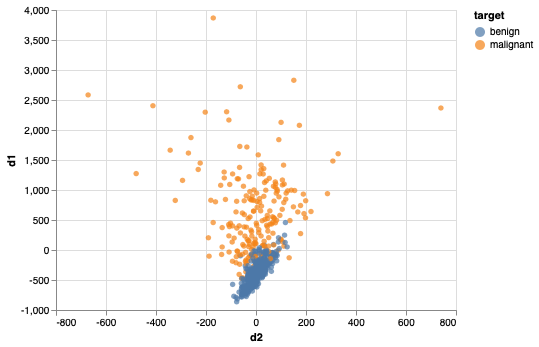

In [103]:
chart = alt.Chart(pca)
chart = chart.mark_circle().encode(x='d2:Q')
chart.encode(y='d1:Q', color='target:N').interactive()